In [1]:
from datetime import datetime
from utils.binaries import *
from utils.plotting import *
import uproot
import pickle

15:37:29 (   +1.3s) [INFO   ] -- import logging
15:37:29 (   +78ms) [INFO   ] -- import numpy as np
15:37:29 (    +9ms) [INFO   ] -- import uncertainties
15:37:29 (  +207ms) [INFO   ] -- import pandas as pd
15:37:29 (    +2ms) [INFO   ] -- import binaries.tools as tools
15:37:30 (  +387ms) [INFO   ] -- import matplotlib.pyplot as plt
15:37:30 (  +443ms) [INFO   ] -- import seaborn as so
15:37:30 (   +13ms) [DEBUG  ] -- font size set to 9.5
15:37:30 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:37:30 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:37:30 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:37:30 (    +2ms) [DEBUG  ] -- usetex set to False
15:37:30 (    +5ms) [INFO   ] -- import plotting.tools as plot


In [2]:
def get_start_stop_variance(path):

    file = uproot.open(f'{path}:AugerUpTime')
    variances = np.array(file['ADCVariance'].array(), dtype=float)[:,-7:,:]
    shutter_open_fraction = np.floor(np.array(file['ShutterFraction8ADC'].array())[:,-7:])
    variances *= shutter_open_fraction[:, :, np.newaxis]

    # indices = list(range(len(variances)))
    # indices = [i for i, var in enumerate(variances) if np.mean(var) > 0]
    indices = [i for i, var in enumerate(variances) if np.all(np.logical_and(var.mean(axis=1)>0, var.mean(axis=1)<200))]
    start, stop = file['uptime_gpsStart'].array(), file['uptime_gpsStop'].array()
    return start[indices], stop[indices], variances[indices]

def make_mask(heat_telescope_number, co_pixels):
    with open(f'../heat{heat_telescope_number}_CoOverlap.pkl', 'rb') as heat_overlap:
        heCo_overlap = pickle.load(heat_overlap)

    heat_mask = np.zeros(440)
    for i, pixel in enumerate(heCo_overlap[0]):
        tel, pix = pixel
        heat_mask[i] = co_pixels[tel-3][pix-1]

    return heat_mask

def get_calibration_constant(date, method):

    results = '/cr/data01/filip/xy-calibration/results/'

    # force preclean usage
    # date = '2023-07'

    # force postclean usage
    # date = '2023-11'

    if date < '2023-11':        # before mirror cleaning
        # print('before MC')
        heat1_run = '6020x'
        heat2_run = '6025'
        heat3_run = '6031x'
    else:                       # after mirror cleaning
        # print('after MC')
        heat1_run = '6070'
        heat2_run = '6075'
        heat3_run = '6066'
    
    co6_run = '15925x'
    co5_run = '15984x'
    co4_run = '15934x'
    co3_run = '15941x'

    heat1 = pd.read_csv(f'{results}/outCorr_{heat1_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat2 = pd.read_csv(f'{results}/outCorr_{heat2_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat3 = pd.read_csv(f'{results}/outCorr_{heat3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])

    co6 = pd.read_csv(f'{results}/outCorr_{co6_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co5 = pd.read_csv(f'{results}/outCorr_{co5_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co4 = pd.read_csv(f'{results}/outCorr_{co4_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    co3 = pd.read_csv(f'{results}/outCorr_{co3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    
    get_raw = lambda run : np.ones(440)
    get_cala = lambda run : run.stdCalib.values
    get_xy = lambda run : run.calibConstCorr.values

    match method.lower():
        case 'xy': get_calibration_constants = get_xy
        case 'cala': get_calibration_constants = get_cala
        case _: get_calibration_constants = get_raw

    return [get_calibration_constants(run) for run in [co3, co4, co5, co6, heat1, heat2, heat3]]

In [3]:
files = ['2023-04-01-12utc.root',
         '2023-05-01-12utc.root',
         '2023-06-01-12utc.root',
         '2023-07-01-12utc.root', 
         '2023-08-01-12utc.root', 
         '2023-09-01-12utc.root', 
         '2023-10-01-12utc.root', 
         '2023-11-01-12utc.root', 
         '2023-12-01-12utc.root',
         '2024-01-01-12utc.root',
         '2024-02-01-12utc.root',
         '2024-03-01-12utc.root',
         ]

GPS_OFFSET = 315964800
all_variances_pre_mc, all_times_pre_mc = [[] for _ in range(7)], []
all_variances_post_mc, all_times_post_mc = [[] for _ in range(7)], []
down_pos_variances, down_pos_times = [[] for _ in range(7)], []

for file in files:
    start, stop, var = get_start_stop_variance(f"../NightSkyBackground/{file}")
    mean_time = 0.5 * (start + stop) + GPS_OFFSET

    if file < '2023-10-01-12utc.root':
        variances, times = all_variances_pre_mc, all_times_pre_mc
    if file in ['2023-10-01-12utc.root', '2023-11-01-12utc.root']:
        variances, times = down_pos_variances, down_pos_times
    if file > '2023-11-01-12utc.root':
        variances, times = all_variances_post_mc, all_times_post_mc

    [times.append(time) for time in mean_time]
    for i in range(7): 
        [variances[i].append(point) for point in var[:, i]]

In [4]:
NSB_ratios_pre_MC = [[] for _ in range(3)]
NSB_ratios_down_pos = [[] for _ in range(3)]
NSB_ratios_post_MC = [[] for _ in range(3)]

for all_variances, all_ratios in zip([all_variances_pre_mc, down_pos_variances, all_variances_post_mc], [NSB_ratios_pre_MC, NSB_ratios_down_pos, NSB_ratios_post_MC]):

    coihueco = np.array(all_variances[:4])
    heat = np.array(all_variances[4:])

    for i in range(len(coihueco[0])):

        this_coihueco = coihueco[:, i]
        he1_co_mask = make_mask(1, this_coihueco)
        he2_co_mask = make_mask(2, this_coihueco)
        he3_co_mask = make_mask(3, this_coihueco)
        
        heat1, heat2, heat3 = heat[:, i]
        all_ratios[0].append(heat1 / he1_co_mask)
        all_ratios[1].append(heat2 / he2_co_mask)
        all_ratios[2].append(heat3 / he3_co_mask)

#     print(len(co3), len(he1))
#     break

#     # normalize with calibration constants
#     calibration_constants = get_calibration_constant(key, method)
#     co3_cal, co4_cal, co5_cal, co6_cal, he1_cal, he2_cal, he3_cal = calibration_constants

#     co3 *= co3_cal
#     co4 *= co4_cal
#     co5 *= co5_cal
#     co6 *= co6_cal
#     he1 *= he1_cal
#     he2 *= he2_cal
#     he3 *= he3_cal

#     he1_co_mask = make_mask(1, [co3, co4, co5, co6])
#     he2_co_mask = make_mask(2, [co3, co4, co5, co6])
#     he3_co_mask = make_mask(3, [co3, co4, co5, co6])

#     ratios = [he1 / he1_co_mask, he2 / he2_co_mask, he3 / he3_co_mask]

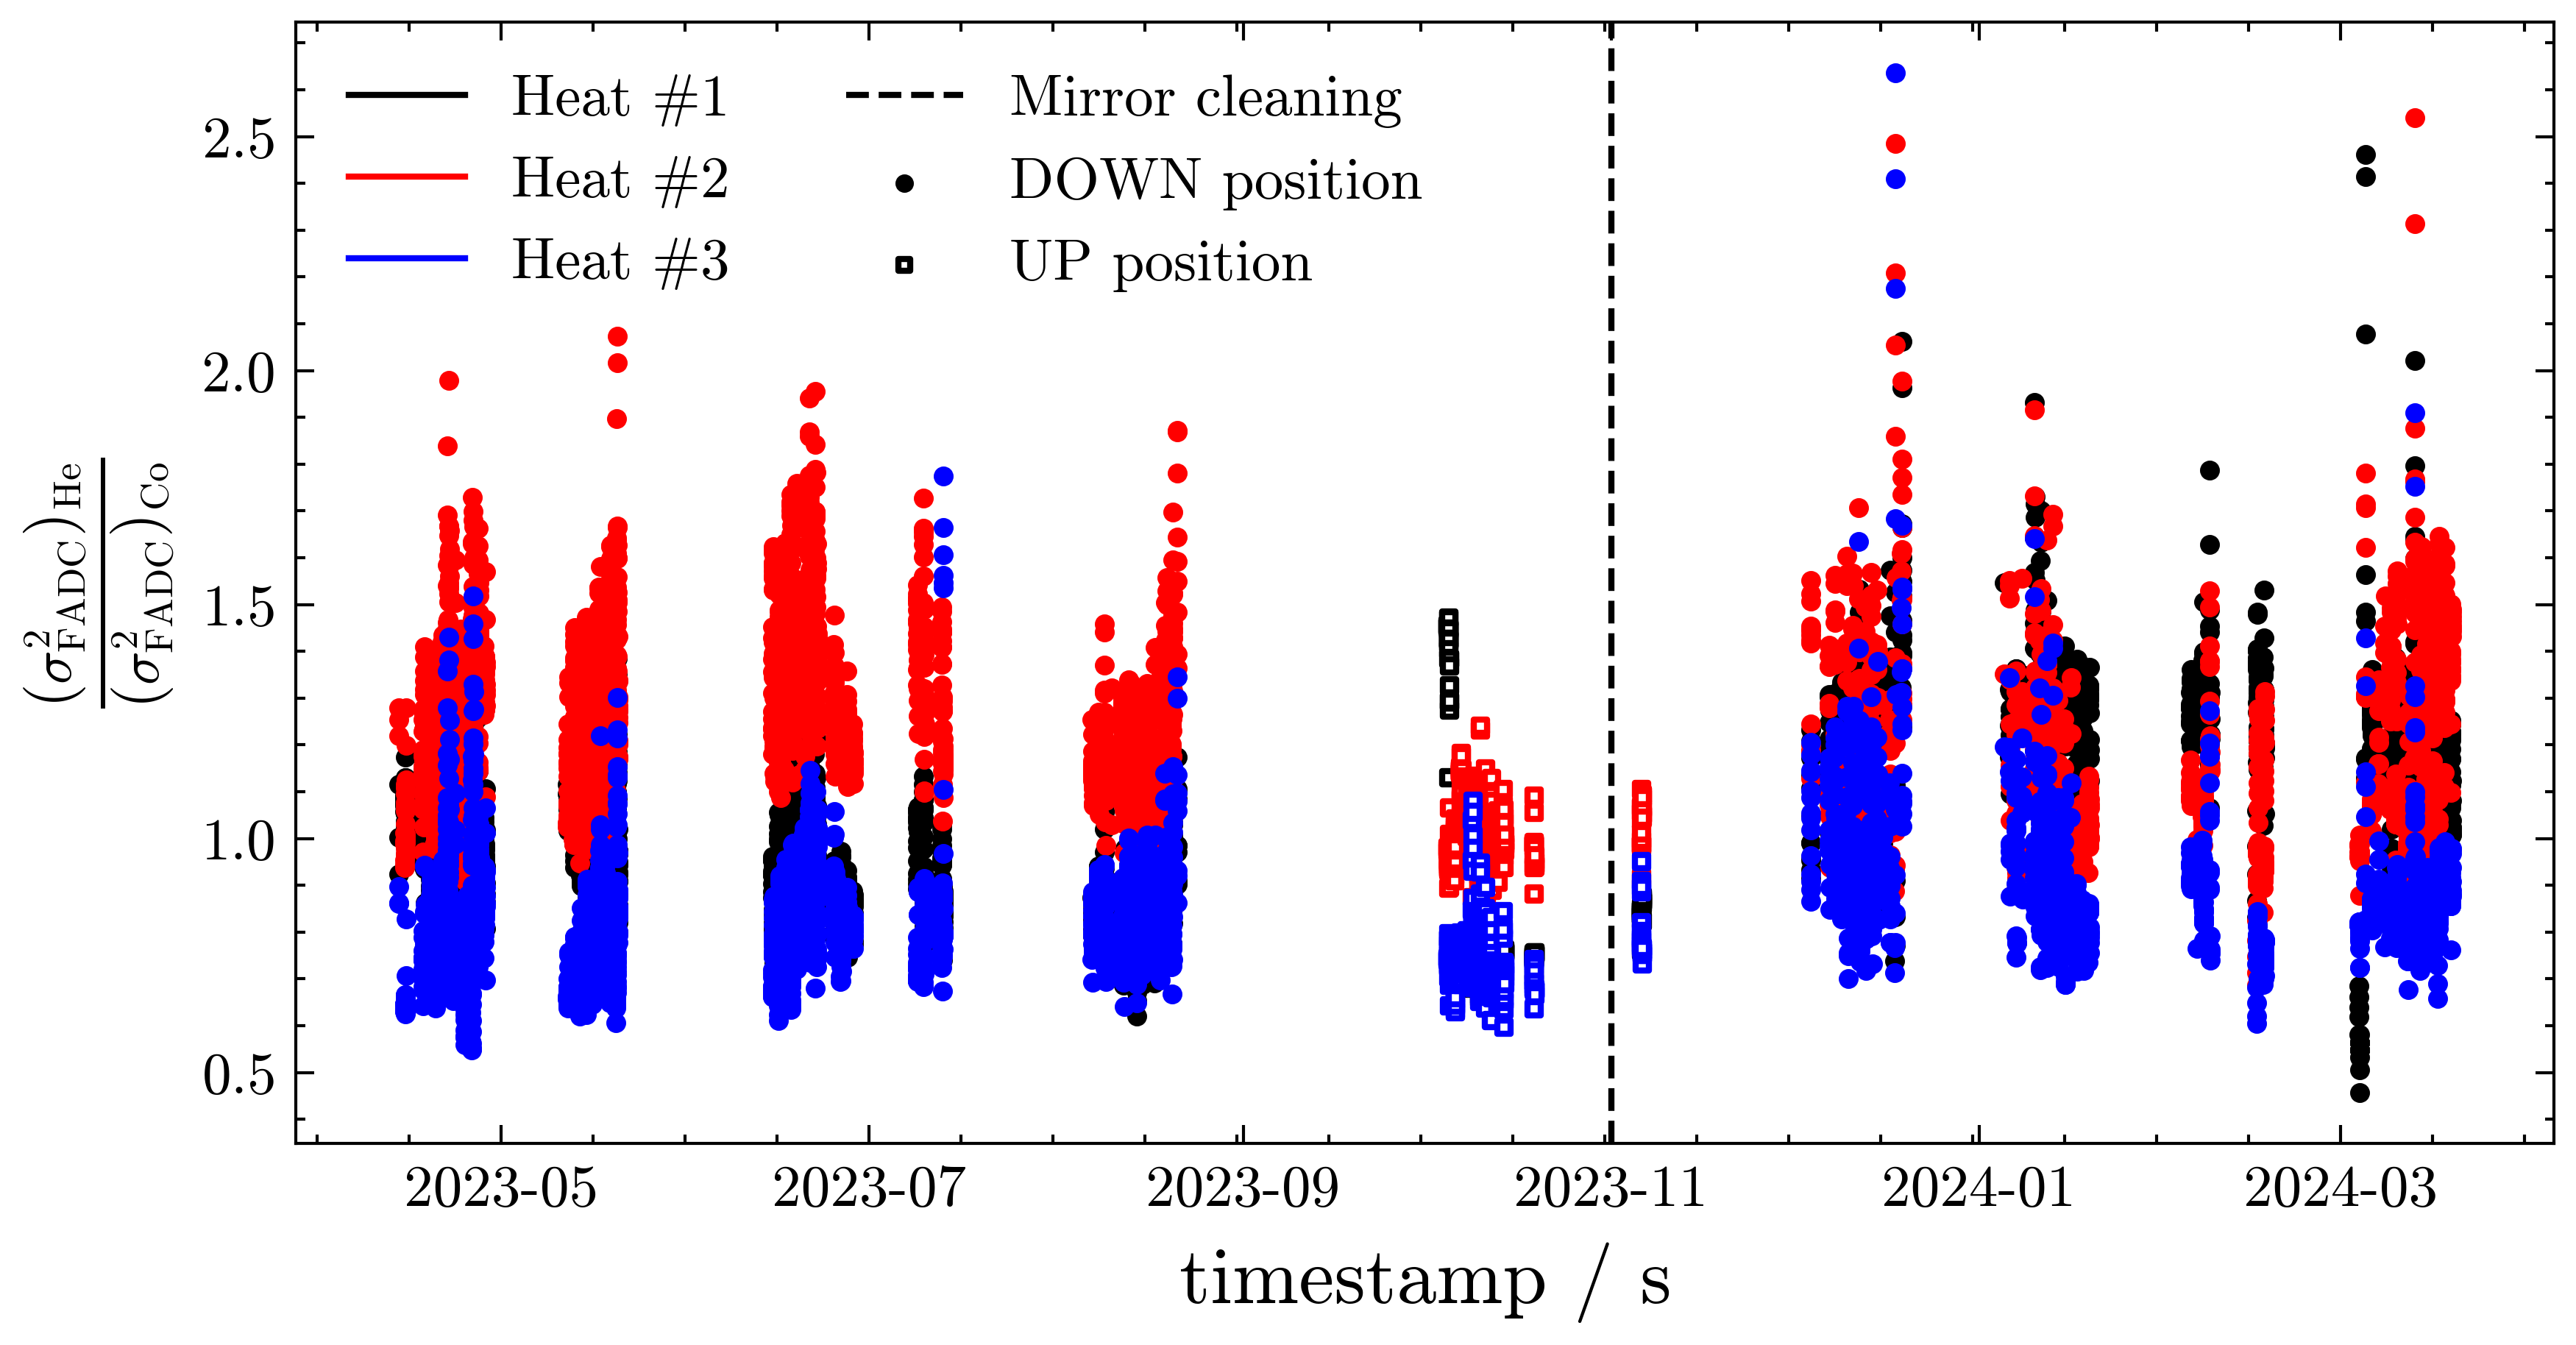

In [7]:
from datetime import datetime

to_timestamps = lambda x : [datetime.fromtimestamp(_) for _ in x]
colors = {0 : 'k', 1 : 'r', 2 : 'b'}


for i, (x, y) in enumerate(zip([all_times_pre_mc, down_pos_times, all_times_post_mc], [NSB_ratios_pre_MC, NSB_ratios_down_pos, NSB_ratios_post_MC])):
    marker = 's' if i == 1 else 'o'

    for tel, NSB in enumerate(y):
        fc = 'white' if i == 1 else colors[tel]
        NSB = np.array(NSB)

        mu, std = NSB.mean(axis=1), NSB.std(axis=1)

        # if i != 1:
        #     params = np.polyfit(x, mu, 1)
        #     drift = np.poly1d(params)
        #     plt.plot(to_timestamps(x), drift(x), zorder=1, label=None if i==0 else f'Heat #{tel + 1}', c=colors[tel])

        plt.scatter(to_timestamps(x), mu, zorder=2, c=fc, marker=marker, edgecolor=colors[tel], s=5)

plt.xlabel('timestamp / s')
plt.ylabel(fr'$\frac{{\left(\sigma^2_\mathrm{{FADC}}\right)_\mathrm{{He}}}}{{\left(\sigma^2_\mathrm{{FADC}}\right)_\mathrm{{Co}}}}$')

plt.plot([],[], c='k', label='Heat #1', ls='solid')
plt.plot([],[], c='r', label='Heat #2', ls='solid')
plt.plot([],[], c='b', label='Heat #3', ls='solid')
plt.axvline(datetime(2023, 11, 1), ls='--', label='Mirror cleaning')
plt.scatter([],[], color='k', label='DOWN position')
plt.scatter([],[], marker='s', color='w', edgecolors='k', label='UP position')

plt.legend(ncol=2)

# every_nth = 2
# for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
#     if n % every_nth != 0:
#         label.set_visible(False)
plot.save(path='XY-heat/HeCoOverlap/time_plot.png')
